🔄 Extracting ELAMO features on full data...


100%|██████████| 18082/18082 [01:36<00:00, 188.12it/s]


⚖️ Applying SMOTE to full dataset...
✂️ Splitting into train and test...
🔍 Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=Non

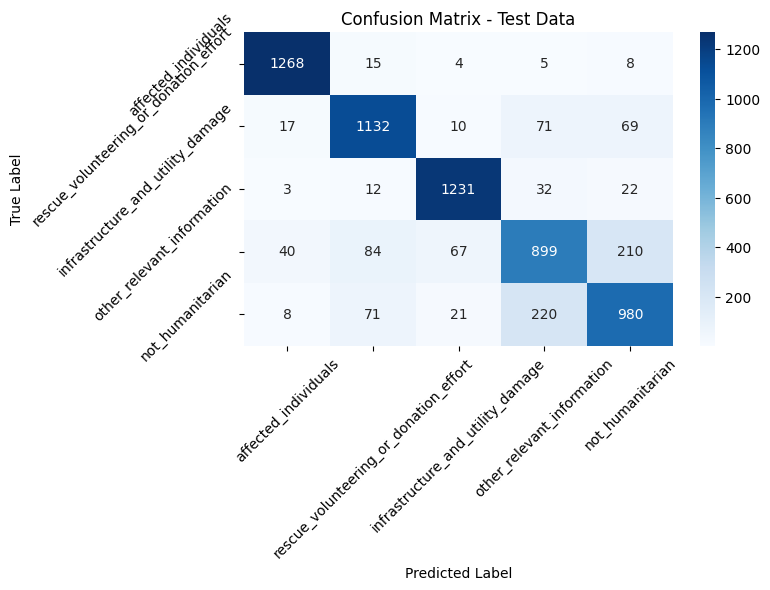

In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_md")
embedding_dim = 300

# Load full dataset
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Handle missing and normalize text + labels
df['processed_data'] = df['processed_data'].fillna("")
df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

# Label encoding
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['humanitarian_class'].map(label_map).astype(int)

# ELAMO feature extraction
def get_elamo_features(text, model, dim=300):
    doc = model(text)
    tokens = [token for token in doc if token.has_vector and not token.is_stop and not token.is_punct]
    if tokens:
        avg_embedding = np.mean([token.vector for token in tokens], axis=0)
        morph_diversity = len(set(token.tag_ for token in tokens))
    else:
        avg_embedding = np.zeros(dim)
        morph_diversity = 0
    return np.concatenate((avg_embedding, [morph_diversity]))

print("🔄 Extracting ELAMO features on full data...")
elamo_features = np.vstack([get_elamo_features(text, nlp, embedding_dim) for text in tqdm(df['processed_data'])])

# Handcrafted features
df['tweet_length'] = df['processed_data'].apply(len)
df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
handcrafted_features = scaler.fit_transform(df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine ELAMO + handcrafted features
X = np.hstack((elamo_features, handcrafted_features))
y = df['label'].values

# Apply SMOTE on full data
print("⚖️ Applying SMOTE to full dataset...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Train-test split (after balancing)
print("✂️ Splitting into train and test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Hyperparameter tuning
print("🔍 Tuning Random Forest...")
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print("✅ Best Parameters:", random_search.best_params_)

# Train final model
best_rf.fit(X_train, y_train)

# Save model
joblib.dump(best_rf, "/kaggle/working/elamo_rf_model.pkl")
print("📦 Model saved as 'elamo_rf_model.pkl'")

# Evaluation
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_map.keys())
print(f"\n🎯 Test Accuracy: {acc:.4f}")
print("📋 Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
